In [1]:
import pandas as pd
import numpy as np
from functools import reduce
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

/Users/mahdie/opt/anaconda3/envs/physioai/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Load the datasets:

In [2]:
# OAI:
df = pd.read_csv('testdata/0.OAI.csv').drop(columns='Unnamed: 0')
# GLAD
dfg = pd.read_stata('testdata/Glad.dta')

In [3]:
df.shape

(4796, 17)

In [4]:
df

,ID,P02SEX,V00COHORT,V00AGE,P01BMI,V00CESD6,V00P7LKRCV,V00P7RKRCV,V00KOOSQOL,V00CEMPLOY,V00PASE,V00NSAIDS,V00NSAIDRX,V01P7LKRCV,V01P7RKRCV,V01KOOSQOL,V01PASE
0,b'9000099',1.0,1.0,59.0,23.8,1.0,0.0,4.0,25.00,1.0,132.0,1.0,0.0,0.0,0.0,31.25,119.0
1,b'9000296',1.0,2.0,69.0,29.8,1.0,0.0,0.0,100.00,1.0,190.0,0.0,0.0,0.0,0.0,100.00,190.0
2,b'9000622',2.0,1.0,71.0,22.7,1.0,0.0,3.0,50.00,4.0,157.0,0.0,0.0,0.0,6.0,81.25,118.0
3,b'9000798',1.0,1.0,56.0,32.4,2.0,4.0,0.0,43.75,1.0,250.0,1.0,0.0,5.0,0.0,31.25,285.0
4,b'9001104',2.0,2.0,72.0,30.7,1.0,0.0,5.0,37.50,4.0,164.0,0.0,0.0,0.0,4.0,62.50,157.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4791,b'9999365',1.0,2.0,56.0,30.3,2.0,4.0,6.0,18.75,1.0,200.0,0.0,0.0,5.0,5.0,56.25,242.0
4792,b'9999510',1.0,2.0,50.0,28.9,1.0,3.0,0.0,68.75,1.0,315.0,0.0,0.0,3.0,0.0,68.75,NaN
4793,b'9999862',2.0,2.0,61.0,23.7,1.0,0.0,0.0,93.75,4.0,186.0,0.0,0.0,0.0,0.0,100.00,215.0
4794,b'9999865',2.0,2.0,61.0,25.0,2.0,0.0,0.0,100.00,4.0,95.0,0.0,0.0,0.0,0.0,100.00,82.0


##### Hip patients are excluded:

In [5]:
def knee_pain(dfg):
    df_knee_pain = dfg[(dfg['ptb_3754'] == 5.0) | (dfg['ptb_3754'] == 6.0)];
    return df_knee_pain

dfg = knee_pain(dfg)
print(dfg.shape)

(40411, 1240)


##### GLAD Variables

In [6]:
glad_variables = ['age', 'gender', 'fysb_BMI', 'ptb_14618', 'ptb_3777', 'ptb_4145', 'pt12_4145', 'ptb_koos_qol_score', 'pt12_koos_qol_score', 'ptb_3764', 'pt12_3764', 'ptb_3754', 'fysb_3646']
dfg = dfg[glad_variables]
print(dfg.shape)
dfg

(40411, 13)


,age,gender,fysb_BMI,ptb_14618,ptb_3777,ptb_4145,pt12_4145,ptb_koos_qol_score,pt12_koos_qol_score,ptb_3764,pt12_3764,ptb_3754,fysb_3646
35,48,2,25.53,NaN,1.0,10.0,NaN,50.00,NaN,28.0,NaN,6.0,1.0
36,66,2,39.30,NaN,4.0,7.0,8.0,37.50,62.50,49.0,22.0,5.0,2.0
37,48,2,35.93,NaN,1.0,4.0,5.0,31.25,62.50,87.0,58.0,5.0,1.0
39,47,2,26.83,NaN,4.0,4.0,5.0,25.00,43.75,95.0,37.0,5.0,1.0
41,64,2,24.61,NaN,1.0,10.0,8.0,43.75,68.75,44.0,26.0,6.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66192,76,2,23.23,2.0,4.0,4.0,NaN,25.00,NaN,39.0,NaN,6.0,1.0
66194,66,1,25.68,1.0,6.0,8.0,NaN,43.75,NaN,33.0,NaN,5.0,1.0
66197,75,2,24.16,1.0,4.0,6.0,NaN,50.00,NaN,52.0,NaN,6.0,2.0
66201,62,1,21.30,1.0,1.0,5.0,NaN,43.75,NaN,21.0,NaN,6.0,2.0


In [7]:
print(dfg.shape)
outcomes_glad = ['ptb_koos_qol_score', 'pt12_koos_qol_score', 'ptb_3764', 'pt12_3764', 'ptb_4145', 'pt12_4145']
dfg.dropna(subset=outcomes_glad, inplace=True)

(40411, 13)


In [8]:
print(dfg.shape)

(22063, 13)


In [9]:
# drop NaN value:
print(dfg.shape)
print(dfg.isna().sum())
print("--------------------")
dfg = dfg.dropna()
print(dfg.isna().sum())
print(dfg.shape)
print("--------------------")

(22063, 13)
age                      0
gender                   0
fysb_BMI                92
ptb_14618              375
ptb_3777                 2
ptb_4145                 0
pt12_4145                0
ptb_koos_qol_score       0
pt12_koos_qol_score      0
ptb_3764                 0
pt12_3764                0
ptb_3754                 0
fysb_3646                0
dtype: int64
--------------------
age                    0
gender                 0
fysb_BMI               0
ptb_14618              0
ptb_3777               0
ptb_4145               0
pt12_4145              0
ptb_koos_qol_score     0
pt12_koos_qol_score    0
ptb_3764               0
pt12_3764              0
ptb_3754               0
fysb_3646              0
dtype: int64
(21594, 13)
--------------------


In [10]:
df

,ID,P02SEX,V00COHORT,V00AGE,P01BMI,V00CESD6,V00P7LKRCV,V00P7RKRCV,V00KOOSQOL,V00CEMPLOY,V00PASE,V00NSAIDS,V00NSAIDRX,V01P7LKRCV,V01P7RKRCV,V01KOOSQOL,V01PASE
0,b'9000099',1.0,1.0,59.0,23.8,1.0,0.0,4.0,25.00,1.0,132.0,1.0,0.0,0.0,0.0,31.25,119.0
1,b'9000296',1.0,2.0,69.0,29.8,1.0,0.0,0.0,100.00,1.0,190.0,0.0,0.0,0.0,0.0,100.00,190.0
2,b'9000622',2.0,1.0,71.0,22.7,1.0,0.0,3.0,50.00,4.0,157.0,0.0,0.0,0.0,6.0,81.25,118.0
3,b'9000798',1.0,1.0,56.0,32.4,2.0,4.0,0.0,43.75,1.0,250.0,1.0,0.0,5.0,0.0,31.25,285.0
4,b'9001104',2.0,2.0,72.0,30.7,1.0,0.0,5.0,37.50,4.0,164.0,0.0,0.0,0.0,4.0,62.50,157.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4791,b'9999365',1.0,2.0,56.0,30.3,2.0,4.0,6.0,18.75,1.0,200.0,0.0,0.0,5.0,5.0,56.25,242.0
4792,b'9999510',1.0,2.0,50.0,28.9,1.0,3.0,0.0,68.75,1.0,315.0,0.0,0.0,3.0,0.0,68.75,NaN
4793,b'9999862',2.0,2.0,61.0,23.7,1.0,0.0,0.0,93.75,4.0,186.0,0.0,0.0,0.0,0.0,100.00,215.0
4794,b'9999865',2.0,2.0,61.0,25.0,2.0,0.0,0.0,100.00,4.0,95.0,0.0,0.0,0.0,0.0,100.00,82.0


### Preparing the Variables:

#### Create new dataframe just with OA patients in OAI dataset:

In [11]:
print(df.shape)
df.V00COHORT.value_counts()

(4796, 17)


V00COHORT
2.0    3284
1.0    1390
3.0     122
Name: count, dtype: int64

In [12]:
df_OA = df[df["V00COHORT"] == 1]
print(df_OA.shape)

(1390, 17)


#### Create Pain variable in baseline and followup in OAI

In [13]:
########### Pain in baseline in OAI
# create new variable of knee pain (left knee) knee pain (right knee) in OAI to compare with VAS in GLAD
df_OA['Knee_pain_baseline'] = np.where(df_OA['V00P7LKRCV'] > df_OA['V00P7RKRCV'], df_OA['V00P7LKRCV'], df_OA['V00P7RKRCV'])
########### Pain in followup in OAI
# create new variable of knee pain (left knee) knee pain (right knee) in OAI to compare with VAS in GLAD
df_OA['Knee_pain_followup'] = np.where(df_OA['V01P7LKRCV'] > df_OA['V01P7RKRCV'], df_OA['V01P7LKRCV'], df_OA['V01P7RKRCV'])

/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_6902/1191590789.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_OA['Knee_pain_baseline'] = np.where(df_OA['V00P7LKRCV'] > df_OA['V00P7RKRCV'], df_OA['V00P7LKRCV'], df_OA['V00P7RKRCV'])
/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_6902/1191590789.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_OA['Knee_pain_followup'] = np.where(df_OA['V01P7LKRCV'] > df_OA['V01P7RKRCV'], df_OA['V01P7LKRCV'], df_OA['V01P7RKRCV'])


In [14]:
df_OA['Knee_pain_baseline'] = df_OA['Knee_pain_baseline'] * 10
df_OA['Knee_pain_followup'] = df_OA['Knee_pain_followup'] * 10

/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_6902/1898877121.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_OA['Knee_pain_baseline'] = df_OA['Knee_pain_baseline'] * 10
/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_6902/1898877121.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_OA['Knee_pain_followup'] = df_OA['Knee_pain_followup'] * 10


##### Create pain medication (nonprescription & prescription)

In [15]:
#baseline
df_OA[['V00NSAIDS', 'V00NSAIDRX']] = df_OA[['V00NSAIDS', 'V00NSAIDRX']].apply(pd.to_numeric, errors='coerce')
# Merge 
df_OA['pain_medication_baseline'] = df_OA[['V00NSAIDS', 'V00NSAIDRX']].max(axis=1)

print(df_OA.pain_medication_baseline.value_counts(dropna=False))

pain_medication_baseline
0.0    941
1.0    446
NaN      3
Name: count, dtype: int64


/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_6902/3547613810.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_OA[['V00NSAIDS', 'V00NSAIDRX']] = df_OA[['V00NSAIDS', 'V00NSAIDRX']].apply(pd.to_numeric, errors='coerce')
/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_6902/3547613810.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_OA['pain_medication_baseline'] = df_OA[['V00NSAIDS', 'V00NSAIDRX']].max(axis=1)


In [16]:
oai_variables = ["ID", "P02SEX", "V00COHORT", "V00AGE", "P01BMI", "V00CESD6",	
                 "V00KOOSQOL", "V00CEMPLOY", "V00PASE",	
                 "V01KOOSQOL", "V01PASE", "Knee_pain_baseline", "Knee_pain_followup", "pain_medication_baseline"]
df_OA = df_OA[oai_variables]
df_OA.shape

(1390, 14)

In [17]:
df_OA

,ID,P02SEX,V00COHORT,V00AGE,P01BMI,V00CESD6,V00KOOSQOL,V00CEMPLOY,V00PASE,V01KOOSQOL,V01PASE,Knee_pain_baseline,Knee_pain_followup,pain_medication_baseline
0,b'9000099',1.0,1.0,59.0,23.8,1.0,25.00,1.0,132.0,31.25,119.0,40.0,0.0,1.0
2,b'9000622',2.0,1.0,71.0,22.7,1.0,50.00,4.0,157.0,81.25,118.0,30.0,60.0,0.0
3,b'9000798',1.0,1.0,56.0,32.4,2.0,43.75,1.0,250.0,31.25,285.0,40.0,50.0,1.0
8,b'9002116',1.0,1.0,61.0,36.5,2.0,43.75,4.0,147.0,50.00,86.0,80.0,80.0,0.0
17,b'9003380',1.0,1.0,64.0,33.1,1.0,68.75,4.0,159.0,56.25,204.0,50.0,40.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4767,b'9993846',1.0,1.0,68.0,31.6,1.0,56.25,1.0,36.0,81.25,0.0,30.0,0.0,1.0
4776,b'9996086',1.0,1.0,53.0,24.8,1.0,43.75,4.0,116.0,75.00,197.0,40.0,70.0,0.0
4777,b'9996098',1.0,1.0,72.0,35.8,1.0,50.00,4.0,183.0,75.00,162.0,40.0,10.0,0.0
4781,b'9996865',2.0,1.0,79.0,24.1,1.0,75.00,1.0,162.0,68.75,111.0,30.0,30.0,1.0


In [18]:
print(df_OA.shape)

(1390, 14)


In [19]:
outcomes = ['Knee_pain_baseline', 'Knee_pain_followup', 'V00PASE', 'V01PASE', 'V00KOOSQOL', 'V01KOOSQOL']
df_OA.dropna(subset=outcomes, inplace=True)

In [20]:
print(df_OA.shape)

(1204, 14)


In [21]:
df_OA

,ID,P02SEX,V00COHORT,V00AGE,P01BMI,V00CESD6,V00KOOSQOL,V00CEMPLOY,V00PASE,V01KOOSQOL,V01PASE,Knee_pain_baseline,Knee_pain_followup,pain_medication_baseline
0,b'9000099',1.0,1.0,59.0,23.8,1.0,25.00,1.0,132.0,31.25,119.0,40.0,0.0,1.0
2,b'9000622',2.0,1.0,71.0,22.7,1.0,50.00,4.0,157.0,81.25,118.0,30.0,60.0,0.0
3,b'9000798',1.0,1.0,56.0,32.4,2.0,43.75,1.0,250.0,31.25,285.0,40.0,50.0,1.0
8,b'9002116',1.0,1.0,61.0,36.5,2.0,43.75,4.0,147.0,50.00,86.0,80.0,80.0,0.0
17,b'9003380',1.0,1.0,64.0,33.1,1.0,68.75,4.0,159.0,56.25,204.0,50.0,40.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4766,b'9993833',1.0,1.0,75.0,32.1,1.0,50.00,1.0,64.0,43.75,60.0,70.0,90.0,0.0
4767,b'9993846',1.0,1.0,68.0,31.6,1.0,56.25,1.0,36.0,81.25,0.0,30.0,0.0,1.0
4776,b'9996086',1.0,1.0,53.0,24.8,1.0,43.75,4.0,116.0,75.00,197.0,40.0,70.0,0.0
4777,b'9996098',1.0,1.0,72.0,35.8,1.0,50.00,4.0,183.0,75.00,162.0,40.0,10.0,0.0


##### Dron NaN value:

In [22]:
df_OA.isna().sum()

ID                           0
P02SEX                       0
V00COHORT                    0
V00AGE                       0
P01BMI                       2
V00CESD6                    22
V00KOOSQOL                   0
V00CEMPLOY                  12
V00PASE                      0
V01KOOSQOL                   0
V01PASE                      0
Knee_pain_baseline           0
Knee_pain_followup           0
pain_medication_baseline     3
dtype: int64

In [23]:
df_OA.dropna(inplace=True)

In [24]:
df_OA.isna().sum()

ID                          0
P02SEX                      0
V00COHORT                   0
V00AGE                      0
P01BMI                      0
V00CESD6                    0
V00KOOSQOL                  0
V00CEMPLOY                  0
V00PASE                     0
V01KOOSQOL                  0
V01PASE                     0
Knee_pain_baseline          0
Knee_pain_followup          0
pain_medication_baseline    0
dtype: int64

In [25]:
df = df_OA
print(df.shape)

(1167, 14)


In [26]:
df.V00PASE.value_counts().sort_index().head(20)


V00PASE
0.0      1
3.0      1
10.0     1
14.0     1
18.0     1
21.0     1
25.0     9
27.0    13
28.0     1
30.0     7
31.0     1
32.0     2
33.0     2
34.0     2
35.0     2
36.0     2
37.0     1
38.0     1
39.0     4
40.0     1
Name: count, dtype: int64

In [27]:
df.shape

(1167, 14)

In [28]:
dfg.shape

(21594, 13)

#### Convert PASE (continues) to UCLA (Category)

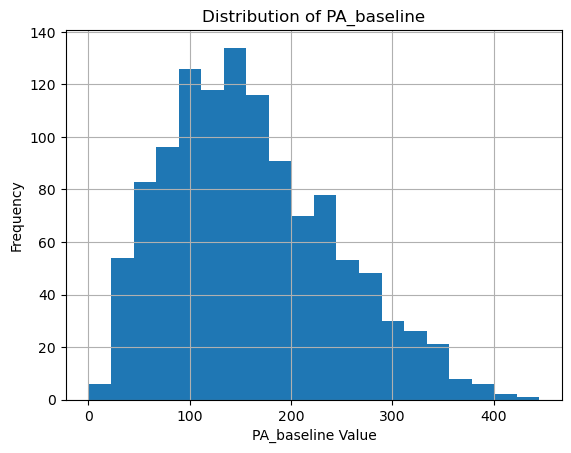

In [29]:
df['V00PASE'].dropna().hist(bins=20) 
plt.title('Distribution of PA_baseline')
plt.xlabel('PA_baseline Value')
plt.ylabel('Frequency')
plt.show() 

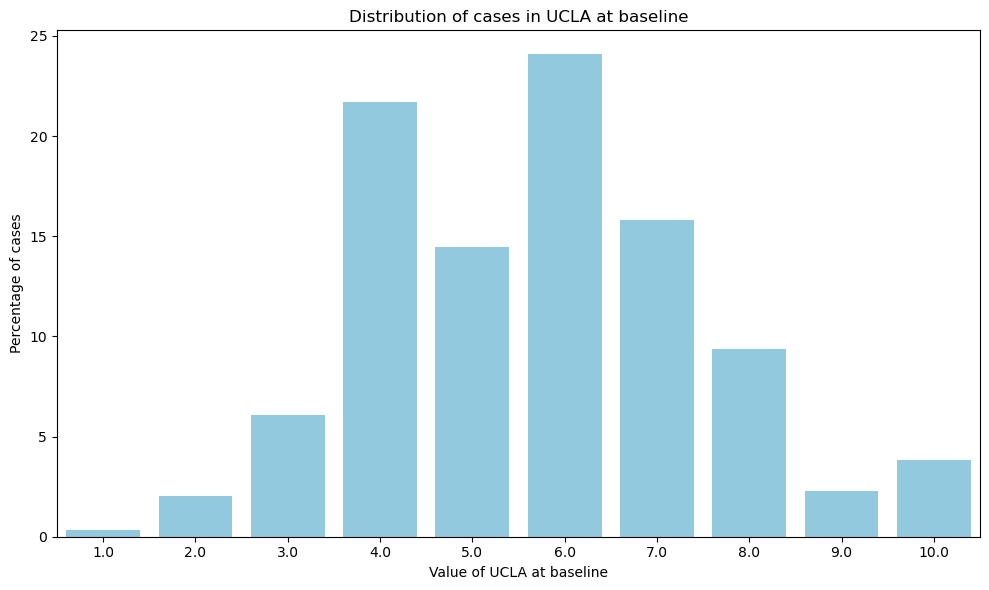

In [30]:
# Calculate the percentage for each category
total_cases = len(dfg)
category_percentages = (dfg['ptb_4145'].value_counts(normalize=True) * 100).sort_index()

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the countplot with percentage values
sns.barplot(x=category_percentages.index, y=category_percentages.values, color='skyblue', ax=ax)

# Set the labels and title
plt.xlabel('Value of UCLA at baseline')
plt.ylabel('Percentage of cases')
plt.title('Distribution of cases in UCLA at baseline')

# Display the plot
plt.tight_layout()
plt.show()

In [31]:
print(df.V00PASE.max())
print(df.V00PASE.min())

445.0
0.0


In [32]:
df.sort_values(by='V00PASE', ascending=True, inplace=True)

##### Baseline

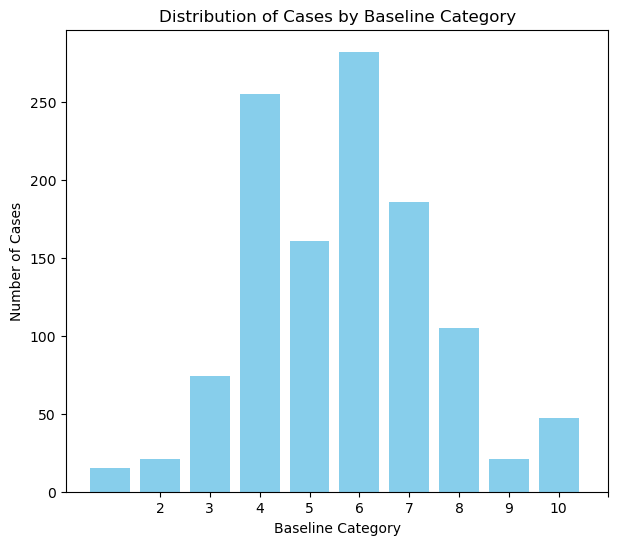

In [33]:
percentages = [1, 2, 6, 22, 14, 24, 16, 9, 2, 4] # It cames from GLAD UCLA distribution
cumulative_percentages = np.cumsum(percentages) / 100.0  # Normalizing to 0-1 range


quantile_breakpoints = df['V00PASE'].quantile(cumulative_percentages)


df['PA_baseline_category'] = pd.cut(df['V00PASE'], bins=[-np.inf] + quantile_breakpoints.tolist(), labels=range(1, 11))


# Count the number of cases per category
category_counts = df['PA_baseline_category'].value_counts().sort_index()


plt.figure(figsize=(7, 6))
plt.bar(category_counts.index.astype(str), category_counts.values, color='skyblue')  
plt.xlabel('Baseline Category')
plt.ylabel('Number of Cases')
plt.title('Distribution of Cases by Baseline Category')
plt.xticks(range(1, 11))  
plt.show()


In [34]:
cases_in_each_category = df['PA_baseline_category'].value_counts().sort_index()
print(cases_in_each_category)


PA_baseline_category
1      15
2      21
3      74
4     255
5     161
6     282
7     186
8     105
9      21
10     47
Name: count, dtype: int64


In [35]:
category_ranges = df.groupby('PA_baseline_category')['V00PASE'].agg([min, max])
print(category_ranges)


                        min    max
PA_baseline_category              
1                       0.0   25.0
2                      27.0   30.0
3                      31.0   59.0
4                      60.0  111.0
5                     112.0  140.0
6                     141.0  196.0
7                     197.0  252.0
8                     253.0  306.0
9                     308.0  322.0
10                    324.0  445.0


/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_6902/4104941463.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_ranges = df.groupby('PA_baseline_category')['V00PASE'].agg([min, max])
/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_6902/4104941463.py:1: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  category_ranges = df.groupby('PA_baseline_category')['V00PASE'].agg([min, max])
/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_6902/4104941463.py:1: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pand

/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_6902/3138127594.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_ranges = df.groupby('PA_baseline_category')['V00PASE'].agg([min, max])
/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_6902/3138127594.py:8: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  category_ranges = df.groupby('PA_baseline_category')['V00PASE'].agg([min, max])
/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_6902/3138127594.py:8: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pand

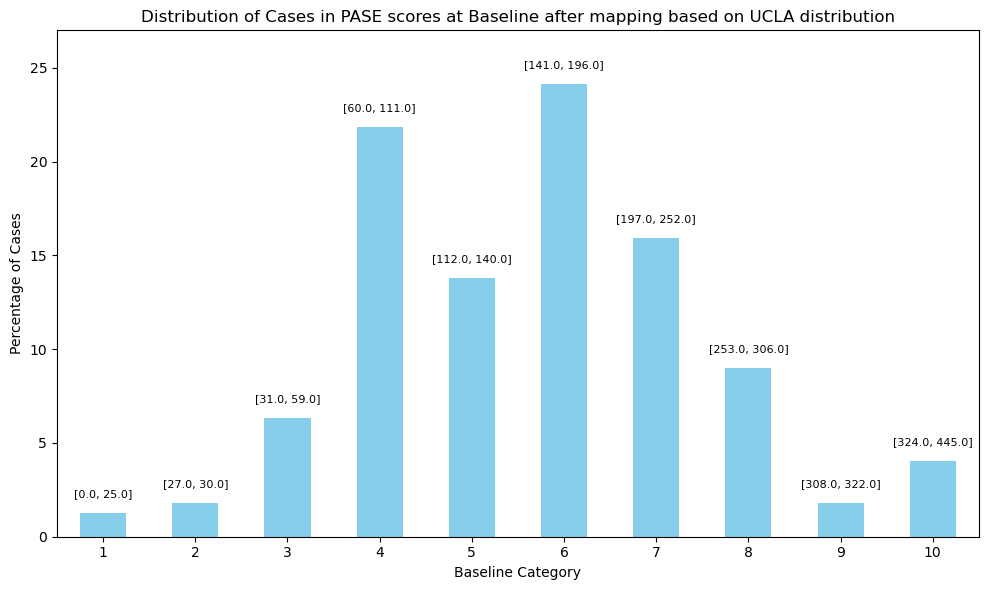

In [36]:
category_counts = df['PA_baseline_category'].value_counts().sort_index()


total_cases = category_counts.sum()
category_percentages = (category_counts / total_cases * 100).round(2)


category_ranges = df.groupby('PA_baseline_category')['V00PASE'].agg([min, max])


fig, ax = plt.subplots(figsize=(10, 6))
category_percentages.plot(kind='bar', color='skyblue', ax=ax)


plt.ylim(0, 27)


for i, (idx, percentage) in enumerate(category_percentages.items()):
    min_val = category_ranges.loc[idx, 'min']
    max_val = category_ranges.loc[idx, 'max']
    annotation_text = f'[{min_val}, {max_val}]'
    ax.annotate(annotation_text, (i, percentage), textcoords="offset points", xytext=(0,10),
                ha='center', va='bottom', fontsize=8)


ax.set_xlabel('Baseline Category')
ax.set_ylabel('Percentage of Cases')
ax.set_title('Distribution of Cases in PASE scores at Baseline after mapping based on UCLA distribution')
ax.set_xticklabels(range(1, len(category_counts) + 1), rotation=0)


plt.tight_layout()
plt.show()


In [37]:
df.V01PASE.isna().sum()

0

##### Is there overlap?

In [38]:
category_ranges = df.groupby('PA_baseline_category')['V00PASE'].agg([min, max])

category_ranges['shifted_max'] = category_ranges['max'].shift(1)

category_ranges['has_overlap'] = category_ranges['min'] <= category_ranges['shifted_max']

print(category_ranges[['min', 'shifted_max', 'has_overlap']])


                        min  shifted_max  has_overlap
PA_baseline_category                                 
1                       0.0          NaN        False
2                      27.0         25.0        False
3                      31.0         30.0        False
4                      60.0         59.0        False
5                     112.0        111.0        False
6                     141.0        140.0        False
7                     197.0        196.0        False
8                     253.0        252.0        False
9                     308.0        306.0        False
10                    324.0        322.0        False


/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_6902/1350431571.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_ranges = df.groupby('PA_baseline_category')['V00PASE'].agg([min, max])
/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_6902/1350431571.py:1: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  category_ranges = df.groupby('PA_baseline_category')['V00PASE'].agg([min, max])
/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_6902/1350431571.py:1: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pand

/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_6902/480000849.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_ranges = df.groupby('PA_baseline_category')['V00PASE'].agg([min, max])
/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_6902/480000849.py:7: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  category_ranges = df.groupby('PA_baseline_category')['V00PASE'].agg([min, max])
/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_6902/480000849.py:7: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas,

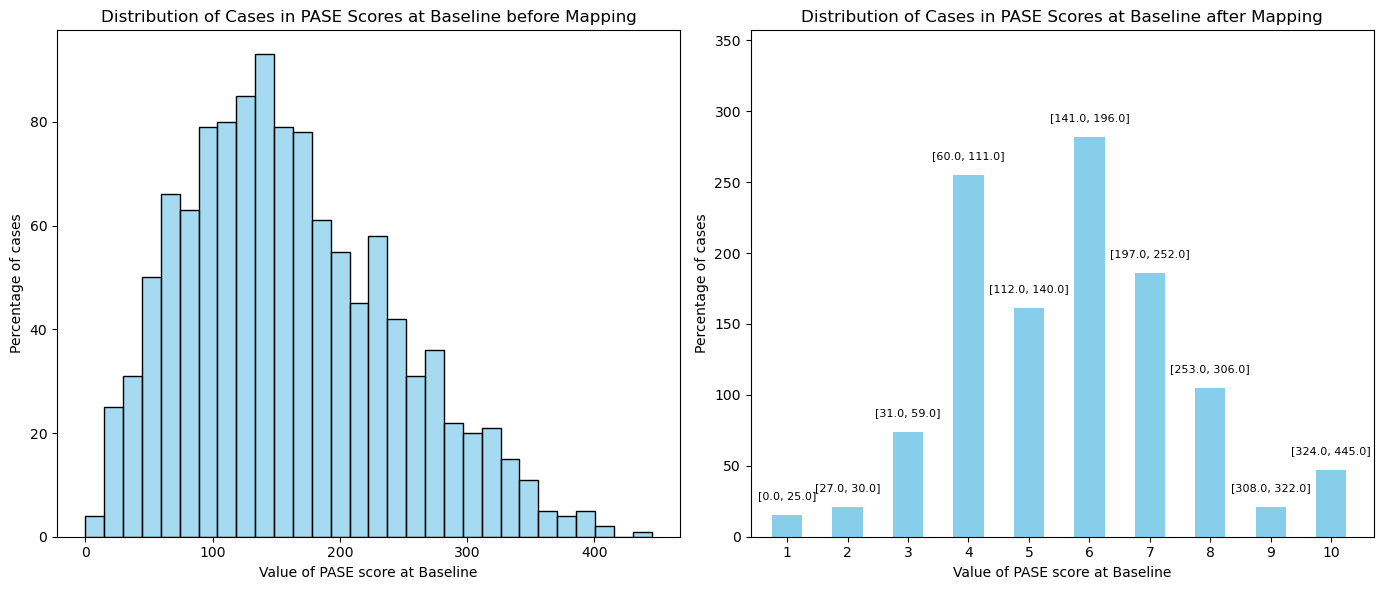

In [39]:
category_counts = df['PA_baseline_category'].value_counts().sort_index()

total_cases = category_counts.sum()
category_percentages = (category_counts / total_cases * 100).round(2)


category_ranges = df.groupby('PA_baseline_category')['V00PASE'].agg([min, max])


fig, axes = plt.subplots(1, 2, figsize=(14, 6))


sns.histplot(data=df, x='V00PASE', bins=30, color='skyblue', ax=axes[0])
axes[0].set_title('Distribution of Cases in PASE Scores at Baseline before Mapping')
axes[0].set_xlabel('Value of PASE score at Baseline')
axes[0].set_ylabel('Percentage of cases')


category_counts.plot(kind='bar', color='skyblue', ax=axes[1])


axes[1].set_ylim(0, category_counts.max() + 75)  # Increase the y-limit for better spacing


axes[1].set_xlim(-0.6, len(category_counts) - 0.3)


for i, (idx, count) in enumerate(category_counts.items()):
    min_val = category_ranges.loc[idx, 'min']
    max_val = category_ranges.loc[idx, 'max']
    annotation_text = f'[{min_val}, {max_val}]'
    axes[1].annotate(annotation_text, (i, count), textcoords="offset points", xytext=(0,10),
                     ha='center', va='bottom', fontsize=8)


axes[1].set_xlabel('Value of PASE score at Baseline')
axes[1].set_ylabel('Percentage of cases')
axes[1].set_title('Distribution of Cases in PASE Scores at Baseline after Mapping')
axes[1].set_xticklabels(range(1, len(category_counts) + 1), rotation=0)


plt.tight_layout()

plt.show()


/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_6902/1518117723.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_ranges = df.groupby('PA_baseline_category')['V00PASE'].agg([min, max])
/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_6902/1518117723.py:7: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  category_ranges = df.groupby('PA_baseline_category')['V00PASE'].agg([min, max])
/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_6902/1518117723.py:7: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pand

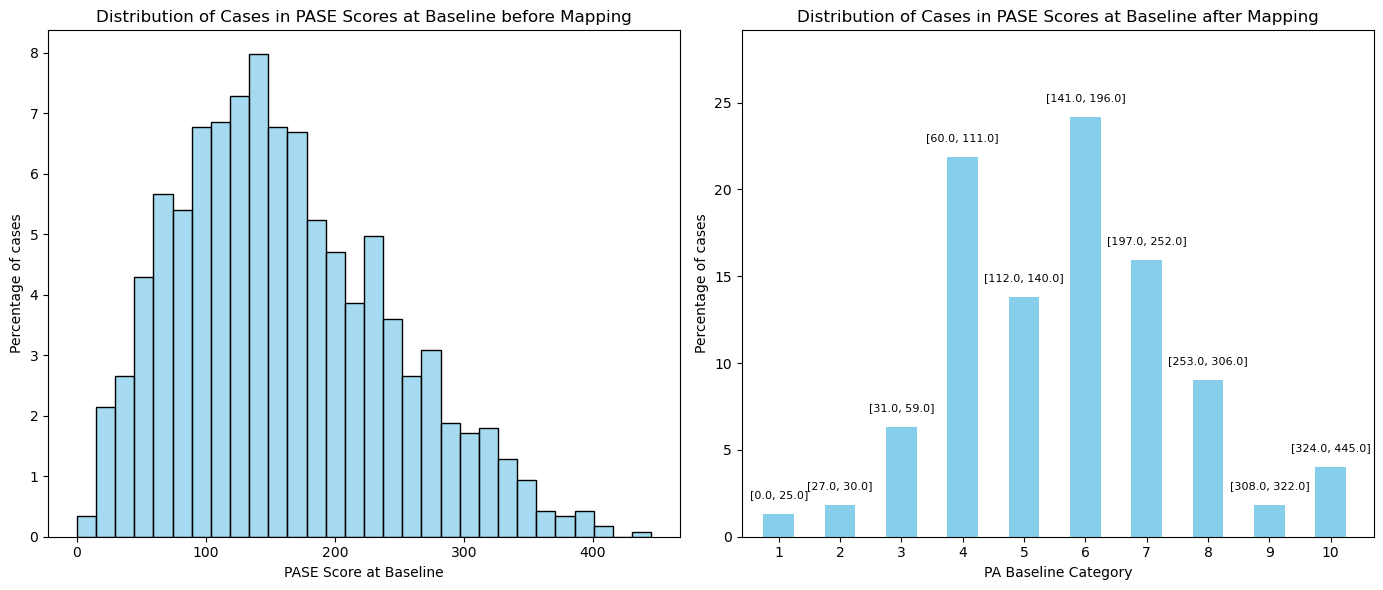

In [40]:
# Calculate the category counts and percentages
category_counts = df['PA_baseline_category'].value_counts().sort_index()
total_cases = category_counts.sum()
category_percentages = (category_counts / total_cases * 100).round(2)

# Calculate the min and max values for each category
category_ranges = df.groupby('PA_baseline_category')['V00PASE'].agg([min, max])

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot the distribution of PASE scores as a histogram (showing percentages)
sns.histplot(data=df, x='V00PASE', bins=30, color='skyblue', ax=axes[0], stat='percent')
axes[0].set_title('Distribution of Cases in PASE Scores at Baseline before Mapping')
axes[0].set_xlabel('PASE Score at Baseline')
axes[0].set_ylabel('Percentage of cases')

# Plot the category percentages as a bar chart
category_percentages.plot(kind='bar', color='skyblue', ax=axes[1])

# Set the y-limit for better spacing (adjust as needed)
axes[1].set_ylim(0, category_percentages.max() + 5)
axes[1].set_xlim(-0.6, len(category_percentages) - 0.3)

# Annotate each bar with the min and max range only
for i, (idx, percentage) in enumerate(category_percentages.items()):
    min_val = category_ranges.loc[idx, 'min']
    max_val = category_ranges.loc[idx, 'max']
    annotation_text = f'[{min_val}, {max_val}]'
    axes[1].annotate(annotation_text, (i, percentage), textcoords="offset points", xytext=(0,10),
                     ha='center', va='bottom', fontsize=8)

# Set labels and titles
axes[1].set_xlabel('PA Baseline Category')
axes[1].set_ylabel('Percentage of cases')
axes[1].set_title('Distribution of Cases in PASE Scores at Baseline after Mapping')
axes[1].set_xticklabels(range(1, len(category_percentages) + 1), rotation=0)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


##### Follow up:

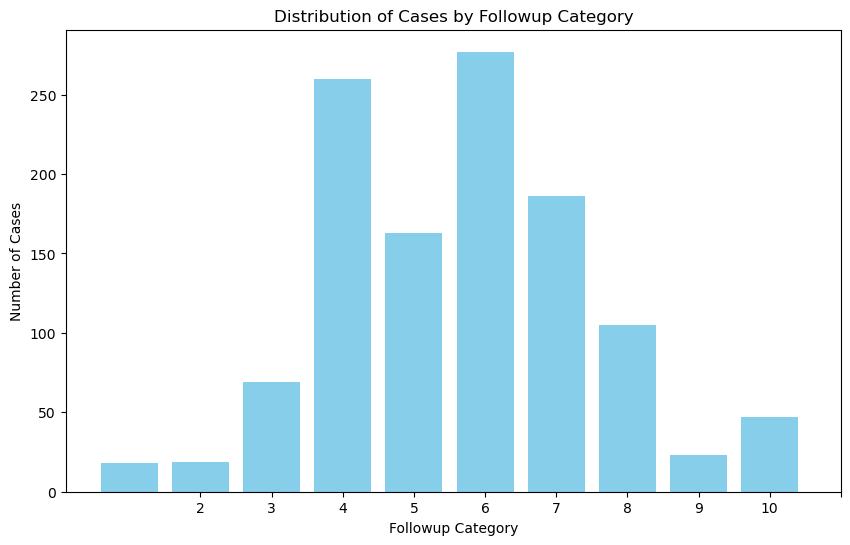

In [41]:
percentages = [1, 2, 6, 22, 14, 24, 16, 9, 2, 4]
cumulative_percentages = np.cumsum(percentages) / 100.0  # Normalizing to 0-1 range

quantile_breakpoints = df['V01PASE'].quantile(cumulative_percentages)

df['PA_followup_category'] = pd.cut(df['V01PASE'], bins=[-np.inf] + quantile_breakpoints.tolist(), labels=range(1, 11))

category_counts = df['PA_followup_category'].value_counts().sort_index()


plt.figure(figsize=(10, 6))
plt.bar(category_counts.index.astype(str), category_counts.values, color='skyblue')  # Convert index to string for x-axis labels
plt.xlabel('Followup Category')
plt.ylabel('Number of Cases')
plt.title('Distribution of Cases by Followup Category')
plt.xticks(range(1, 11))  
plt.show()

/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_6902/1346056780.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_ranges = df.groupby('PA_followup_category')['V01PASE'].agg([min, max])
/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_6902/1346056780.py:6: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  category_ranges = df.groupby('PA_followup_category')['V01PASE'].agg([min, max])
/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_6902/1346056780.py:6: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pand

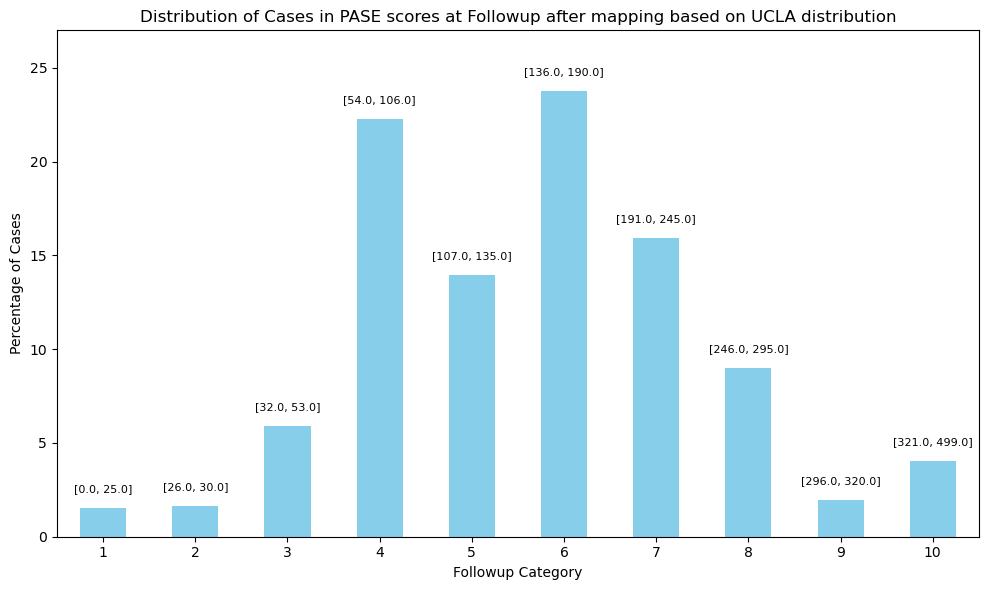

In [42]:
category_counts = df['PA_followup_category'].value_counts().sort_index()

total_cases = category_counts.sum()
category_percentages = (category_counts / total_cases * 100).round(2)

category_ranges = df.groupby('PA_followup_category')['V01PASE'].agg([min, max])


fig, ax = plt.subplots(figsize=(10, 6))
category_percentages.plot(kind='bar', color='skyblue', ax=ax)


plt.ylim(0, 27)


for i, (idx, percentage) in enumerate(category_percentages.items()):
    min_val = category_ranges.loc[idx, 'min']
    max_val = category_ranges.loc[idx, 'max']
    annotation_text = f'[{min_val}, {max_val}]'
    ax.annotate(annotation_text, (i, percentage), textcoords="offset points", xytext=(0,10),
                ha='center', va='bottom', fontsize=8)


ax.set_xlabel('Followup Category')
ax.set_ylabel('Percentage of Cases')
ax.set_title('Distribution of Cases in PASE scores at Followup after mapping based on UCLA distribution')
ax.set_xticklabels(range(1, len(category_counts) + 1), rotation=0)


plt.tight_layout()
plt.show()


/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_6902/2352295617.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_ranges = df.groupby('PA_followup_category')['V01PASE'].agg([min, max])
/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_6902/2352295617.py:8: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  category_ranges = df.groupby('PA_followup_category')['V01PASE'].agg([min, max])
/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_6902/2352295617.py:8: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pand

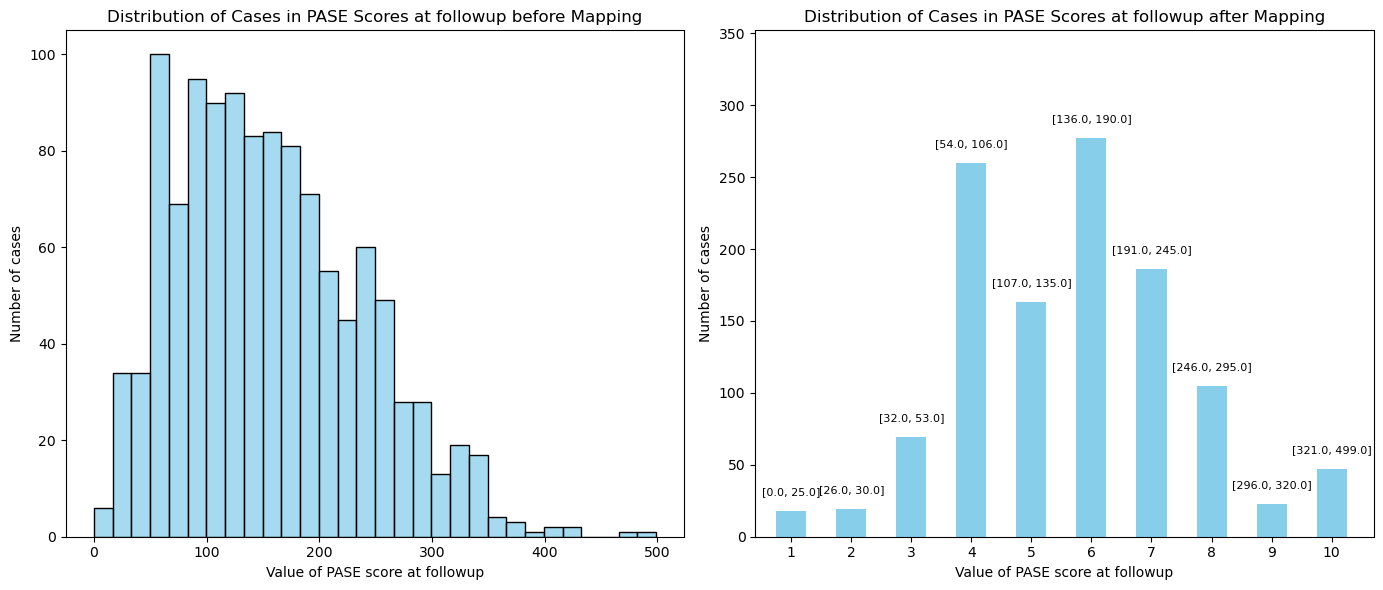

In [43]:
category_counts = df['PA_followup_category'].value_counts().sort_index()


total_cases = category_counts.sum()
category_percentages = (category_counts / total_cases * 100).round(2)


category_ranges = df.groupby('PA_followup_category')['V01PASE'].agg([min, max])


fig, axes = plt.subplots(1, 2, figsize=(14, 6))


sns.histplot(data=df, x='V01PASE', bins=30, color='skyblue', ax=axes[0])
axes[0].set_title('Distribution of Cases in PASE Scores at followup before Mapping')
axes[0].set_xlabel('Value of PASE score at followup')
axes[0].set_ylabel('Number of cases')


category_counts.plot(kind='bar', color='skyblue', ax=axes[1])


axes[1].set_ylim(0, category_counts.max() + 75)  # Increase the y-limit for better spacing


axes[1].set_xlim(-0.6, len(category_counts) - 0.3)


for i, (idx, count) in enumerate(category_counts.items()):
    min_val = category_ranges.loc[idx, 'min']
    max_val = category_ranges.loc[idx, 'max']
    annotation_text = f'[{min_val}, {max_val}]'
    axes[1].annotate(annotation_text, (i, count), textcoords="offset points", xytext=(0,10),
                     ha='center', va='bottom', fontsize=8)


axes[1].set_xlabel('Value of PASE score at followup')
axes[1].set_ylabel('Number of cases')
axes[1].set_title('Distribution of Cases in PASE Scores at followup after Mapping')
axes[1].set_xticklabels(range(1, len(category_counts) + 1), rotation=0)


plt.tight_layout()


plt.show()


##### Depression: Make mappable depression in GLAD with OAI

In [44]:
# In GLAD:
print("Before maping: ")
print(dfg['ptb_14618'].value_counts())

mapping_dict = {
    1: 1,  # Not anxious or depressed
    2: 1,  # Slightly anxious or depressed
    3: 2,  # Moderately anxious or depressed
    4: 3,  # Severely anxious or depressed
    5: 4   # Extremely anxious or depressed
}

# Apply the mapping to the 'ptb_14618' column
dfg['ptb_14618_depression'] = dfg['ptb_14618'].map(mapping_dict)
print("------------------------------")
print("After maping: ")
print(dfg['ptb_14618_depression'].value_counts())

Before maping: 
ptb_14618
1.0    16966
2.0     3418
3.0      994
4.0      195
5.0       21
Name: count, dtype: int64
------------------------------
After maping: 
ptb_14618_depression
1    20384
2      994
3      195
4       21
Name: count, dtype: int64


/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_6902/2641146032.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfg['ptb_14618_depression'] = dfg['ptb_14618'].map(mapping_dict)


In [45]:
# In OAI:
print(df['V00CESD6'].value_counts())

V00CESD6
1.0    881
2.0    234
3.0     31
4.0     21
Name: count, dtype: int64


In [46]:
print("df", df.shape)
print("dfg", dfg.shape)

df (1167, 16)
dfg (21594, 14)


##### Employment status

In [47]:
# OAI
# Define the mapping dictionary
mapping_dict = {
    1: 1,  # Value 1 maps to 1
    3: 2,  # Value 3 maps to 2
    4: 3   # Value 4 maps to 3
}
# Apply the mapping to the 'V00CEMPLOY' column and create a new column 'Employment_Status'
df['Employment_status'] = df['V00CEMPLOY'].map(mapping_dict)

In [48]:
df.Employment_status.value_counts()

Employment_status
1.0    714
3.0    362
2.0     78
Name: count, dtype: int64

In [49]:
dfg.ptb_3777.value_counts()

ptb_3777
4.0    11562
1.0     6782
6.0     1372
7.0      550
3.0      507
2.0      451
5.0      370
Name: count, dtype: int64

In [50]:
# GLAD
# Define the mapping dictionary
mapping_dict = {
    1: 1,  # Value 1 maps to 1
    2: 2,  # Value 2 maps to 2
    5: 3   # Value 5 maps to 3
}
# Apply the mapping to the 'V00CEMPLOY' column and create a new column 'Employment_Status'
dfg['ptb_3777_employment'] = dfg['ptb_3777'].map(mapping_dict)

/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_6902/3227345162.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfg['ptb_3777_employment'] = dfg['ptb_3777'].map(mapping_dict)


In [51]:
dfg.ptb_3777_employment.value_counts()

ptb_3777_employment
1.0    6782
2.0     451
3.0     370
Name: count, dtype: int64

In [52]:
df

,ID,P02SEX,V00COHORT,V00AGE,P01BMI,V00CESD6,V00KOOSQOL,V00CEMPLOY,V00PASE,V01KOOSQOL,V01PASE,Knee_pain_baseline,Knee_pain_followup,pain_medication_baseline,PA_baseline_category,PA_followup_category,Employment_status
1439,b'9336746',1.0,1.0,75.0,27.2,1.0,75.00,4.0,0.0,100.00,55.0,0.0,0.0,0.0,1,4,3.0
4680,b'9971275',1.0,1.0,77.0,33.6,1.0,37.50,4.0,3.0,50.00,72.0,50.0,30.0,0.0,1,4,3.0
923,b'9223980',1.0,1.0,76.0,31.0,2.0,56.25,4.0,10.0,62.50,229.0,10.0,0.0,0.0,1,7,3.0
3578,b'9745368',1.0,1.0,69.0,31.8,2.0,62.50,1.0,14.0,68.75,37.0,30.0,30.0,0.0,1,3,1.0
30,b'9005132',1.0,1.0,74.0,29.6,1.0,50.00,1.0,18.0,43.75,124.0,70.0,40.0,0.0,1,5,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1832,b'9417544',2.0,1.0,46.0,26.9,2.0,56.25,1.0,390.0,68.75,327.0,60.0,50.0,0.0,10,10,1.0
2214,b'9484333',1.0,1.0,54.0,27.6,2.0,68.75,1.0,399.0,68.75,327.0,20.0,30.0,0.0,10,10,1.0
3300,b'9686777',2.0,1.0,56.0,27.5,1.0,43.75,1.0,404.0,56.25,174.0,40.0,50.0,0.0,10,6,1.0
4495,b'9929102',1.0,1.0,57.0,33.6,2.0,68.75,1.0,415.0,68.75,329.0,40.0,90.0,1.0,10,10,1.0


In [53]:
# Remove no needed columns
df.drop(columns=['V00COHORT', 'V00CEMPLOY', 'V00PASE', 'V01PASE'], inplace=True)
dfg.drop(columns=['ptb_14618', 'ptb_3777'], inplace=True)

/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_6902/2028158472.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfg.drop(columns=['ptb_14618', 'ptb_3777'], inplace=True)


In [54]:
print(dfg.shape)
print(dfg.isna().sum())
print("--------------------")
dfg.dropna(inplace=True)
print(dfg.isna().sum())
print(dfg.shape)

(21594, 13)
age                         0
gender                      0
fysb_BMI                    0
ptb_4145                    0
pt12_4145                   0
ptb_koos_qol_score          0
pt12_koos_qol_score         0
ptb_3764                    0
pt12_3764                   0
ptb_3754                    0
fysb_3646                   0
ptb_14618_depression        0
ptb_3777_employment     13991
dtype: int64
--------------------
age                     0
gender                  0
fysb_BMI                0
ptb_4145                0
pt12_4145               0
ptb_koos_qol_score      0
pt12_koos_qol_score     0
ptb_3764                0
pt12_3764               0
ptb_3754                0
fysb_3646               0
ptb_14618_depression    0
ptb_3777_employment     0
dtype: int64
(7603, 13)


/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_6902/3451658158.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfg.dropna(inplace=True)


In [55]:
######### Reorder the columns in the  df and dfg
new_column_order_df = ['V00AGE', 'P02SEX', 'P01BMI', 'V00CESD6', 'Employment_status', 'pain_medication_baseline', 'PA_baseline_category', 'PA_followup_category', 'Knee_pain_baseline', 'Knee_pain_followup', 'V00KOOSQOL','V01KOOSQOL']
df = df_OA[new_column_order_df]

new_column_order_dfg = ['age', 'gender', 'fysb_BMI', 'ptb_14618_depression', 'ptb_3777_employment', 'fysb_3646', 'ptb_4145', 'pt12_4145', 'ptb_3764', 'pt12_3764', 'ptb_koos_qol_score',	'pt12_koos_qol_score']
dfg = dfg[new_column_order_dfg]

In [56]:
print(df.shape)
print(df.isna().sum())
print("--------------------")
df.dropna(inplace=True)
print(df.isna().sum())
print(df.shape)

(1167, 12)
V00AGE                       0
P02SEX                       0
P01BMI                       0
V00CESD6                     0
Employment_status           13
pain_medication_baseline     0
PA_baseline_category         0
PA_followup_category         0
Knee_pain_baseline           0
Knee_pain_followup           0
V00KOOSQOL                   0
V01KOOSQOL                   0
dtype: int64
--------------------
V00AGE                      0
P02SEX                      0
P01BMI                      0
V00CESD6                    0
Employment_status           0
pain_medication_baseline    0
PA_baseline_category        0
PA_followup_category        0
Knee_pain_baseline          0
Knee_pain_followup          0
V00KOOSQOL                  0
V01KOOSQOL                  0
dtype: int64
(1154, 12)


/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_6902/1349324203.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [57]:
print("df", df.shape)
print("dfg", dfg.shape)

df (1154, 12)
dfg (7603, 12)


#### Create Outcome variables:

In [58]:
df

,V00AGE,P02SEX,P01BMI,V00CESD6,Employment_status,pain_medication_baseline,PA_baseline_category,PA_followup_category,Knee_pain_baseline,Knee_pain_followup,V00KOOSQOL,V01KOOSQOL
1439,75.0,1.0,27.2,1.0,3.0,0.0,1,4,0.0,0.0,75.00,100.00
4680,77.0,1.0,33.6,1.0,3.0,0.0,1,4,50.0,30.0,37.50,50.00
923,76.0,1.0,31.0,2.0,3.0,0.0,1,7,10.0,0.0,56.25,62.50
3578,69.0,1.0,31.8,2.0,1.0,0.0,1,3,30.0,30.0,62.50,68.75
30,74.0,1.0,29.6,1.0,1.0,0.0,1,5,70.0,40.0,50.00,43.75
...,...,...,...,...,...,...,...,...,...,...,...,...
1832,46.0,2.0,26.9,2.0,1.0,0.0,10,10,60.0,50.0,56.25,68.75
2214,54.0,1.0,27.6,2.0,1.0,0.0,10,10,20.0,30.0,68.75,68.75
3300,56.0,2.0,27.5,1.0,1.0,0.0,10,6,40.0,50.0,43.75,56.25
4495,57.0,1.0,33.6,2.0,1.0,1.0,10,10,40.0,90.0,68.75,68.75


In [59]:
dfg

,age,gender,fysb_BMI,ptb_14618_depression,ptb_3777_employment,fysb_3646,ptb_4145,pt12_4145,ptb_3764,pt12_3764,ptb_koos_qol_score,pt12_koos_qol_score
861,50,2,22.68,1,1.0,2.0,10.0,10.0,65.0,17.0,31.25,56.25
866,45,1,29.07,1,1.0,1.0,7.0,10.0,96.0,52.0,25.00,43.75
872,46,2,26.10,1,1.0,1.0,3.0,9.0,39.0,25.0,68.75,62.50
874,53,2,28.03,1,1.0,2.0,4.0,4.0,15.0,2.0,62.50,87.50
877,68,2,27.82,1,1.0,1.0,8.0,10.0,15.0,1.0,87.50,93.75
...,...,...,...,...,...,...,...,...,...,...,...,...
60207,55,2,35.63,1,1.0,1.0,8.0,10.0,57.0,9.0,50.00,56.25
60258,61,2,29.34,1,1.0,1.0,3.0,6.0,55.0,8.0,25.00,68.75
60260,62,1,25.88,1,1.0,2.0,3.0,3.0,26.0,77.0,50.00,25.00
60297,47,2,26.51,1,1.0,2.0,4.0,2.0,47.0,92.0,43.75,18.75


##### Physical activity in OAI:

/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_6902/2298696300.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PA_followup_category'] = df['PA_followup_category'].astype('category')
/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_6902/2298696300.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PA_baseline_category'] = df['PA_baseline_category'].astype('category')
/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_6902/2298696300.py:6: SettingWithCopyWarning: 
A 

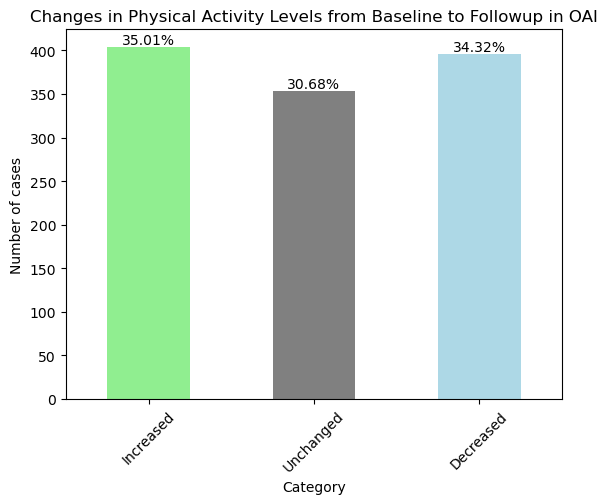

(1154, 16)


In [60]:
# Ensure the columns are of type 'category'
df['PA_followup_category'] = df['PA_followup_category'].astype('category')
df['PA_baseline_category'] = df['PA_baseline_category'].astype('category')

# Convert categories to codes if they are ordinal
df['PA_followup_category_code'] = df['PA_followup_category'].cat.codes
df['PA_baseline_category_code'] = df['PA_baseline_category'].cat.codes

# Calculate the difference
df['PA_change'] = df['PA_followup_category_code'] - df['PA_baseline_category_code']

# Define the function to categorize PA_changes
def categorize_change(PA_change):
    if PA_change > 0:
        return 'Increased'
    elif PA_change < 0:
        return 'Decreased'
    else:
        return 'Unchanged'

# Apply the function to categorize PA_changes
df['PA_change_category'] = df['PA_change'].apply(categorize_change)

# Calculate counts for each category of PA_change
change_counts = df['PA_change_category'].value_counts().reindex(['Increased', 'Unchanged', 'Decreased'])

# Plot
ax = change_counts.plot(kind='bar', color=['lightgreen', 'grey', 'lightblue'])
plt.title('Changes in Physical Activity Levels from Baseline to Followup in OAI')
plt.xlabel('Category')
plt.ylabel('Number of cases')
plt.xticks(rotation=45)

# Calculate the percentages and annotate the bars
total = change_counts.sum()
for p in ax.patches:
    height = p.get_height()
    percentage = f'{100 * height / total:.2f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()
print(df.shape)



In [61]:
df.drop(columns=['PA_baseline_category_code', 'PA_followup_category_code'], inplace=True)

/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_6902/1249540576.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['PA_baseline_category_code', 'PA_followup_category_code'], inplace=True)


##### Physical activity in GLA:D

In [62]:
dfg.pt12_4145.unique()

array([10.,  9.,  4.,  6.,  7.,  8.,  3.,  5.,  2.,  1.])

/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_6902/245959410.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(i, value, f'{percentages[i]}%', ha='center', va='bottom')


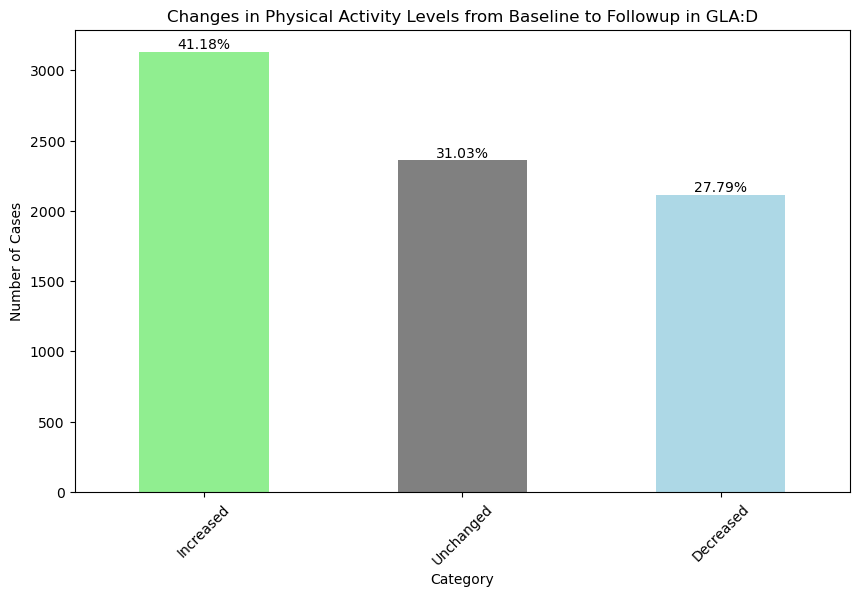

In [63]:
# Calculate the difference
dfg['PA_change'] = dfg['pt12_4145'] - dfg['ptb_4145']

# Categorize the PA_changes
dfg['PA_change_category'] = pd.cut(dfg['PA_change'], bins=[float('-inf'), -0.01, 0.01, float('inf')],
                               labels=['Decreased', 'Unchanged', 'Increased'])

# Ensure the order: Increased, Unchanged, Decreased
order = ['Increased', 'Unchanged', 'Decreased']

# Count the number of cases in each category, reindex to ensure order
PA_change_counts = dfg['PA_change_category'].value_counts().reindex(order)

# Calculate percentages
total = PA_change_counts.sum()
percentages = (PA_change_counts / total * 100).round(2)

# Specify colors for each category
colors = ['lightgreen', 'grey', 'lightblue']

# Visualize the results with a bar plot
fig, ax = plt.subplots(figsize=(10, 6))
PA_change_counts.plot(kind='bar', color=colors, ax=ax)
plt.title('Changes in Physical Activity Levels from Baseline to Followup in GLA:D')
ax.set_xlabel('Category')
ax.set_ylabel('Number of Cases')
plt.xticks(rotation=45)

# Annotate each bar with the percentage of cases
for i, value in enumerate(PA_change_counts.values):
    ax.text(i, value, f'{percentages[i]}%', ha='center', va='bottom')

plt.show()


In [64]:
dfg.shape

(7603, 14)

##### Quality of life in OAI

/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_6902/2682727454.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['QOL_change'] = df['V01KOOSQOL'] - df['V00KOOSQOL']
/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_6902/2682727454.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['QOL_change_category'] = df['QOL_change'].apply(QOL_categorize_change)


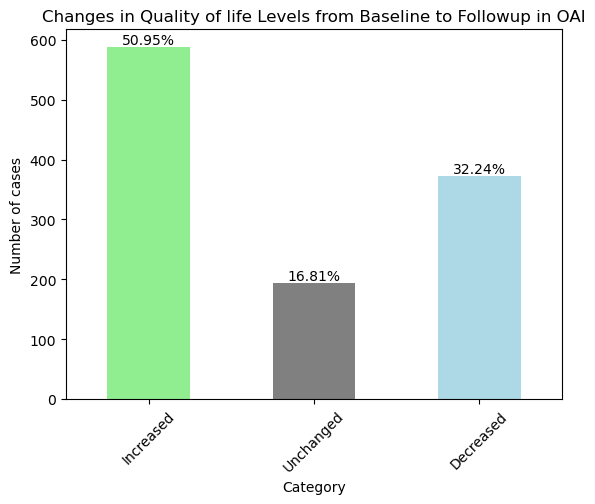

In [65]:
# Calculate the difference
df['QOL_change'] = df['V01KOOSQOL'] - df['V00KOOSQOL']


# Define the function to categorize QOL_changes
def QOL_categorize_change(QOL_change):
    if QOL_change > 0:
        return 'Increased'
    elif QOL_change < 0:
        return 'Decreased'
    
    else:
        return 'Unchanged'

# Apply the function to categorize QOL_changes
df['QOL_change_category'] = df['QOL_change'].apply(QOL_categorize_change)

# Calculate counts for each category of QOL_change
change_counts = df['QOL_change_category'].value_counts().reindex(['Increased', 'Unchanged', 'Decreased'])

# Plot
ax = change_counts.plot(kind='bar', color=['lightgreen', 'grey', 'lightblue'])
plt.title('Changes in Quality of life Levels from Baseline to Followup in OAI')
plt.xlabel('Category')
plt.ylabel('Number of cases')
plt.xticks(rotation=45)

# Calculate the percentages and annotate the bars
total = change_counts.sum()
for p in ax.patches:
    height = p.get_height()
    percentage = f'{100 * height / total:.2f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()


##### Quality of life in OAI: changes of at least 10 points

/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_6902/123599390.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['QOL_change'] = df['V01KOOSQOL'] - df['V00KOOSQOL']
/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_6902/123599390.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['QOL_significant_change_category'] = df['QOL_change'].apply(QOL_categorize_significant_change)


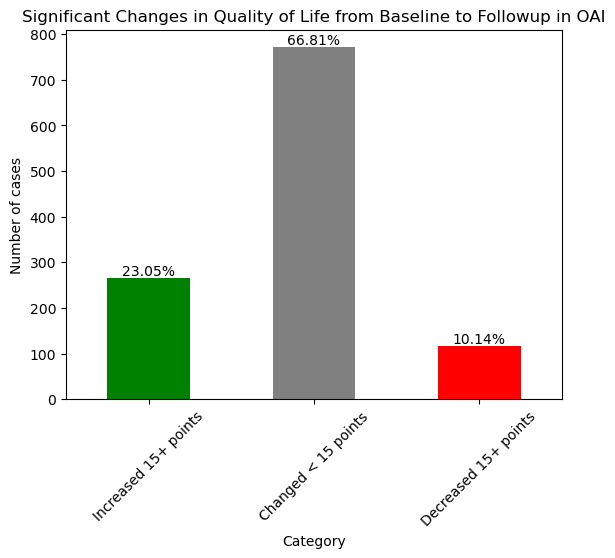

In [66]:
# Calculate the difference
df['QOL_change'] = df['V01KOOSQOL'] - df['V00KOOSQOL']

# Define the function to categorize changes of at least 15 points
def QOL_categorize_significant_change(QOL_change):
    if QOL_change >= 15:
        return 'Increased 15+ points'
    elif QOL_change <= -15:
        return 'Decreased 15+ points'
    else:
        return 'Changed < 15 points'
    
# Apply the function to categorize significant QOL_changes
df['QOL_significant_change_category'] = df['QOL_change'].apply(QOL_categorize_significant_change)

# Calculate counts for each category of significant QOL_change
change_counts = df['QOL_significant_change_category'].value_counts().reindex(['Increased 15+ points', 'Changed < 15 points', 'Decreased 15+ points'])

# Plot
ax = change_counts.plot(kind='bar', color=['green', 'grey', 'red'])
plt.title('Significant Changes in Quality of Life from Baseline to Followup in OAI')
plt.xlabel('Category')
plt.ylabel('Number of cases')
plt.xticks(rotation=45)

# Calculate the percentages and annotate the bars
total = change_counts.sum()
for p in ax.patches:
    height = p.get_height()
    percentage = f'{100 * height / total:.2f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()


##### Quality of life in GLAD

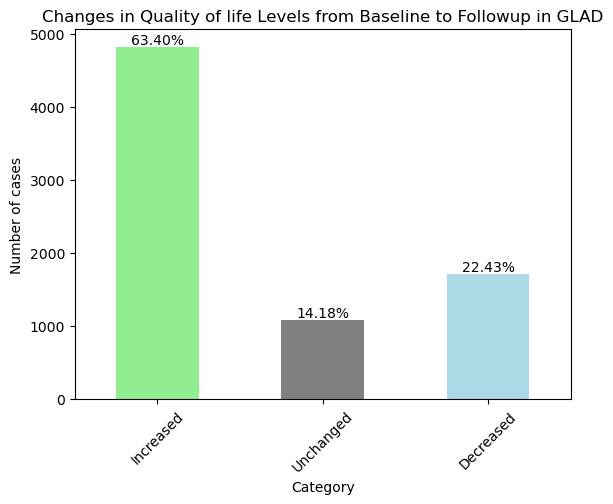

In [67]:
# Calculate the difference 
dfg['QOL_change'] = dfg['pt12_koos_qol_score'] - dfg['ptb_koos_qol_score']


# Define the function to categorize changes
def QOL_categorize_change(QOL_change):
    if QOL_change > 0:
        return 'Increased'
    elif QOL_change < 0:
        return 'Decreased'
    
    else:
        return 'Unchanged'

# Apply the function to categorize QOL_changes
dfg['QOL_change_category'] = dfg['QOL_change'].apply(QOL_categorize_change)

# Calculate counts for each category of QOL_change
QOL_change_counts = dfg['QOL_change_category'].value_counts().reindex(['Increased', 'Unchanged', 'Decreased'])

# Plot
ax = QOL_change_counts.plot(kind='bar', color=['lightgreen', 'grey', 'lightblue'])
plt.title('Changes in Quality of life Levels from Baseline to Followup in GLAD')
plt.xlabel('Category')
plt.ylabel('Number of cases')
plt.xticks(rotation=45)

# Calculate the percentages and annotate the bars
total = QOL_change_counts.sum()
for p in ax.patches:
    height = p.get_height()
    percentage = f'{100 * height / total:.2f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()


##### Quality of life in GLAD: changes of at least 10 point

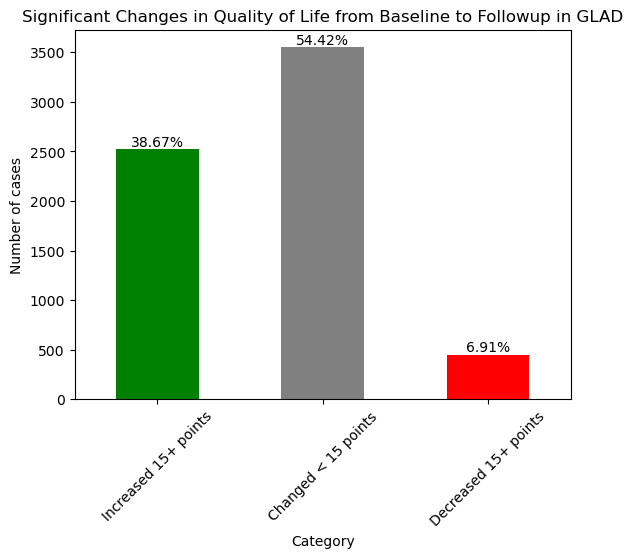

In [68]:
# Calculate the difference
dfg['QOL_change'] = dfg['pt12_koos_qol_score'] - dfg['ptb_koos_qol_score']

# Define the function to categorize changes of at least 15 points
def QOL_categorize_significant_change(QOL_change):
    if QOL_change >= 15:
        return 'Increased 15+ points'
    elif QOL_change <= -15:
        return 'Decreased 15+ points'
    elif QOL_change == 0:
        return 'Unchanged'
    else:
        return 'Changed < 15 points'

# Apply the function to categorize significant QOL_changes
dfg['QOL_significant_change_category'] = dfg['QOL_change'].apply(QOL_categorize_significant_change)

# Calculate counts for each category of significant QOL_change
QOL_significant_change_counts = dfg['QOL_significant_change_category'].value_counts().reindex(['Increased 15+ points', 'Changed < 15 points', 'Decreased 15+ points'])

# Plot
ax = QOL_significant_change_counts.plot(kind='bar', color=['green', 'grey', 'red'])
plt.title('Significant Changes in Quality of Life from Baseline to Followup in GLAD')
plt.xlabel('Category')
plt.ylabel('Number of cases')
plt.xticks(rotation=45)

# Calculate the percentages and annotate the bars
total = QOL_significant_change_counts.sum()
for p in ax.patches:
    height = p.get_height()
    percentage = f'{100 * height / total:.2f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()


##### Pain in OAI

/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_6902/62229189.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pain_change'] = df['Knee_pain_followup'] - df['Knee_pain_baseline']
/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_6902/62229189.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pain_change_category'] = df['pain_change'].apply(pain_categorize_change)


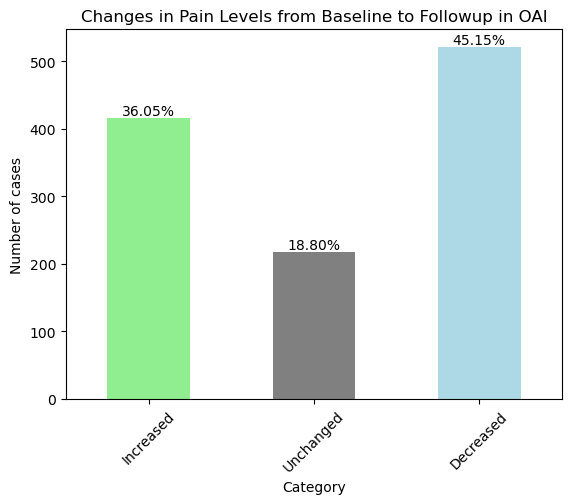

In [69]:
# Calculate the difference
df['pain_change'] = df['Knee_pain_followup'] - df['Knee_pain_baseline']


# Define the function to categorize changes
def pain_categorize_change(pain_change):
    if pain_change > 0:
        return 'Increased'
    elif pain_change < 0:
        return 'Decreased'
    
    else:
        return 'Unchanged'

# Apply the function to categorize pain_changes
df['pain_change_category'] = df['pain_change'].apply(pain_categorize_change)

# Calculate counts for each category of pain_change
change_counts = df['pain_change_category'].value_counts().reindex(['Increased', 'Unchanged', 'Decreased'])

# Plot
ax = change_counts.plot(kind='bar', color=['lightgreen', 'grey', 'lightblue'])
plt.title('Changes in Pain Levels from Baseline to Followup in OAI')
plt.xlabel('Category')
plt.ylabel('Number of cases')
plt.xticks(rotation=45)

# Calculate the percentages and annotate the bars
total = change_counts.sum()
for p in ax.patches:
    height = p.get_height()
    percentage = f'{100 * height / total:.2f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()


##### Pain in OAI: changes of at least 20 points

/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_6902/44598210.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pain_change'] = df['Knee_pain_followup'] - df['Knee_pain_baseline']
/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_6902/44598210.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pain_significant_change_category'] = df['pain_change'].apply(pain_categorize_significant_change)


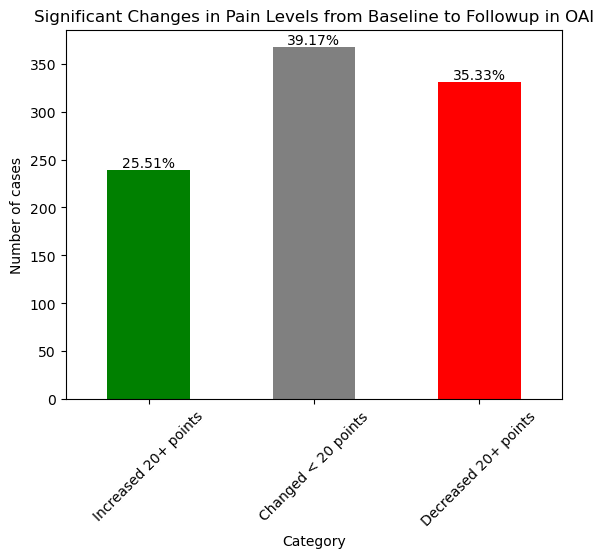

In [70]:
# Calculate the difference
df['pain_change'] = df['Knee_pain_followup'] - df['Knee_pain_baseline']

# Define the function to categorize changes of at least 20 points
def pain_categorize_significant_change(pain_change):
    if pain_change <= -20:
        return 'Decreased 20+ points'
    elif pain_change >= 20:
        return 'Increased 20+ points'
    elif pain_change == 0:
        return 'Unchanged'
    else:
        return 'Changed < 20 points'  # This now clearly means the pain changed but less than 20 points either way
    
# Apply the function to categorize significant pain changes
df['pain_significant_change_category'] = df['pain_change'].apply(pain_categorize_significant_change)

# Calculate counts for each category of significant pain change
change_counts = df['pain_significant_change_category'].value_counts().reindex(['Increased 20+ points', 'Changed < 20 points', 'Decreased 20+ points'])

# Plot
ax = change_counts.plot(kind='bar', color=['green', 'grey', 'red'])
plt.title('Significant Changes in Pain Levels from Baseline to Followup in OAI')
plt.xlabel('Category')
plt.ylabel('Number of cases')
plt.xticks(rotation=45)

# Calculate the percentages and annotate the bars
total = change_counts.sum()
for p in ax.patches:
    height = p.get_height()
    percentage = f'{100 * height / total:.2f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()


##### Pain in GLAD

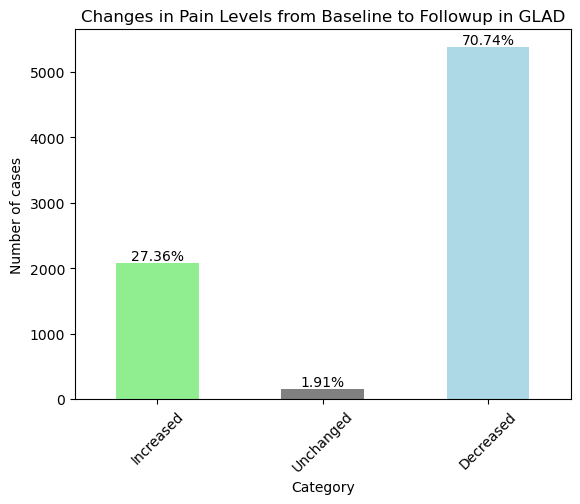

In [71]:
# Calculate the difference
dfg['pain_change'] = dfg['pt12_3764'] - dfg['ptb_3764']


# Define the function to categorize changes
def pain_categorize_change(pain_change):
    if pain_change > 0:
        return 'Increased'
    elif pain_change < 0:
        return 'Decreased'
    
    else:
        return 'Unchanged'

# Apply the function to categorize pain_changes
dfg['pain_change_category'] = dfg['pain_change'].apply(pain_categorize_change)

# Calculate counts for each category of pain_change
pain_change_counts = dfg['pain_change_category'].value_counts().reindex(['Increased', 'Unchanged', 'Decreased'])

# Plot
ax = pain_change_counts.plot(kind='bar', color=['lightgreen', 'grey', 'lightblue'])
plt.title('Changes in Pain Levels from Baseline to Followup in GLAD')
plt.xlabel('Category')
plt.ylabel('Number of cases')
plt.xticks(rotation=45)

# Calculate the percentages and annotate the bars
total = pain_change_counts.sum()
for p in ax.patches:
    height = p.get_height()
    percentage = f'{100 * height / total:.2f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()


##### Pain in GLAD: changes of at least 20 points

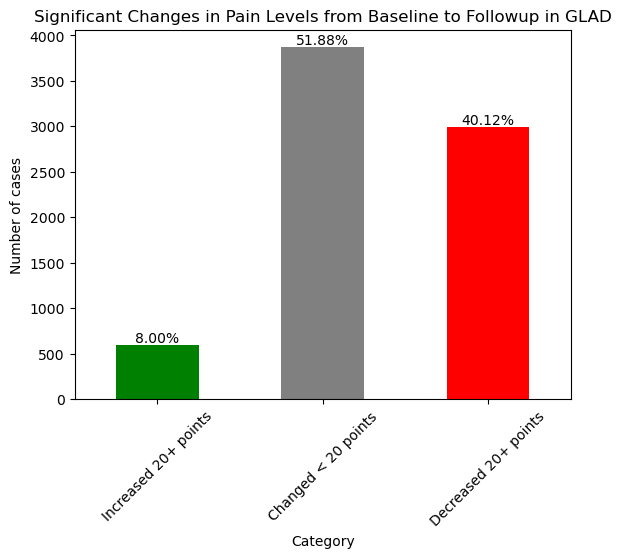

In [72]:
# Calculate the difference
dfg['pain_change'] = dfg['pt12_3764'] - dfg['ptb_3764']

# Define the function to categorize changes of at least 20 points
def pain_categorize_significant_change(pain_change):
    if pain_change <= -20:
        return 'Decreased 20+ points'
    elif pain_change >= 20:
        return 'Increased 20+ points'
    elif pain_change == 0:
        return 'Unchanged'
    else:
        return 'Changed < 20 points'  # This now clearly means the pain changed but less than 20 points either way

# Apply the function to categorize significant pain changes
dfg['pain_significant_change_category'] = dfg['pain_change'].apply(pain_categorize_significant_change)

# Calculate counts for each category of significant pain change
pain_significant_change_counts = dfg['pain_significant_change_category'].value_counts().reindex(['Increased 20+ points', 'Changed < 20 points', 'Decreased 20+ points'])

# Plot
ax = pain_significant_change_counts.plot(kind='bar', color=['green', 'grey', 'red'])
plt.title('Significant Changes in Pain Levels from Baseline to Followup in GLAD')
plt.xlabel('Category')
plt.ylabel('Number of cases')
plt.xticks(rotation=45)

# Calculate the percentages and annotate the bars
total = pain_significant_change_counts.sum()
for p in ax.patches:
    height = p.get_height()
    percentage = f'{100 * height / total:.2f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()


In [73]:
df.columns

Index(['V00AGE', 'P02SEX', 'P01BMI', 'V00CESD6', 'Employment_status',
       'pain_medication_baseline', 'PA_baseline_category',
       'PA_followup_category', 'Knee_pain_baseline', 'Knee_pain_followup',
       'V00KOOSQOL', 'V01KOOSQOL', 'PA_change', 'PA_change_category',
       'QOL_change', 'QOL_change_category', 'QOL_significant_change_category',
       'pain_change', 'pain_change_category',
       'pain_significant_change_category'],
      dtype='object')

In [74]:
dfg

,age,gender,fysb_BMI,ptb_14618_depression,ptb_3777_employment,fysb_3646,ptb_4145,pt12_4145,ptb_3764,pt12_3764,ptb_koos_qol_score,pt12_koos_qol_score,PA_change,PA_change_category,QOL_change,QOL_change_category,QOL_significant_change_category,pain_change,pain_change_category,pain_significant_change_category
861,50,2,22.68,1,1.0,2.0,10.0,10.0,65.0,17.0,31.25,56.25,0.0,Unchanged,25.00,Increased,Increased 15+ points,-48.0,Decreased,Decreased 20+ points
866,45,1,29.07,1,1.0,1.0,7.0,10.0,96.0,52.0,25.00,43.75,3.0,Increased,18.75,Increased,Increased 15+ points,-44.0,Decreased,Decreased 20+ points
872,46,2,26.10,1,1.0,1.0,3.0,9.0,39.0,25.0,68.75,62.50,6.0,Increased,-6.25,Decreased,Changed < 15 points,-14.0,Decreased,Changed < 20 points
874,53,2,28.03,1,1.0,2.0,4.0,4.0,15.0,2.0,62.50,87.50,0.0,Unchanged,25.00,Increased,Increased 15+ points,-13.0,Decreased,Changed < 20 points
877,68,2,27.82,1,1.0,1.0,8.0,10.0,15.0,1.0,87.50,93.75,2.0,Increased,6.25,Increased,Changed < 15 points,-14.0,Decreased,Changed < 20 points
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60207,55,2,35.63,1,1.0,1.0,8.0,10.0,57.0,9.0,50.00,56.25,2.0,Increased,6.25,Increased,Changed < 15 points,-48.0,Decreased,Decreased 20+ points
60258,61,2,29.34,1,1.0,1.0,3.0,6.0,55.0,8.0,25.00,68.75,3.0,Increased,43.75,Increased,Increased 15+ points,-47.0,Decreased,Decreased 20+ points
60260,62,1,25.88,1,1.0,2.0,3.0,3.0,26.0,77.0,50.00,25.00,0.0,Unchanged,-25.00,Decreased,Decreased 15+ points,51.0,Increased,Increased 20+ points
60297,47,2,26.51,1,1.0,2.0,4.0,2.0,47.0,92.0,43.75,18.75,-2.0,Decreased,-25.00,Decreased,Decreased 15+ points,45.0,Increased,Increased 20+ points


In [75]:
df.to_csv('testdata/1.OAI_ready.csv', index=False)
dfg.to_csv('testdata/1.GLAD_ready.csv', index=False)

## Preparing data for Entropy Balancing:

In [76]:
df = pd.read_csv('testdata/1.OAI_ready.csv')
dfg = pd.read_csv('testdata/1.GLAD_ready.csv')
print(df.shape)
print(dfg.shape)

(1154, 20)
(7603, 20)


In [77]:
#### Drop unnecessary columns:
dfg.drop(columns=['PA_change_category', 'pain_change_category', 'pain_significant_change_category', 'QOL_change_category', 'QOL_significant_change_category'], inplace=True)
df.drop(columns=['PA_change_category', 'pain_change_category', 'pain_significant_change_category', 'QOL_change_category', 'QOL_significant_change_category'], inplace=True)
print(df.shape)
print(dfg.shape)

(1154, 15)
(7603, 15)


In [78]:
df

,V00AGE,P02SEX,P01BMI,V00CESD6,Employment_status,pain_medication_baseline,PA_baseline_category,PA_followup_category,Knee_pain_baseline,Knee_pain_followup,V00KOOSQOL,V01KOOSQOL,PA_change,QOL_change,pain_change
0,75.0,1.0,27.2,1.0,3.0,0.0,1,4,0.0,0.0,75.00,100.00,3,25.00,0.0
1,77.0,1.0,33.6,1.0,3.0,0.0,1,4,50.0,30.0,37.50,50.00,3,12.50,-20.0
2,76.0,1.0,31.0,2.0,3.0,0.0,1,7,10.0,0.0,56.25,62.50,6,6.25,-10.0
3,69.0,1.0,31.8,2.0,1.0,0.0,1,3,30.0,30.0,62.50,68.75,2,6.25,0.0
4,74.0,1.0,29.6,1.0,1.0,0.0,1,5,70.0,40.0,50.00,43.75,4,-6.25,-30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1149,46.0,2.0,26.9,2.0,1.0,0.0,10,10,60.0,50.0,56.25,68.75,0,12.50,-10.0
1150,54.0,1.0,27.6,2.0,1.0,0.0,10,10,20.0,30.0,68.75,68.75,0,0.00,10.0
1151,56.0,2.0,27.5,1.0,1.0,0.0,10,6,40.0,50.0,43.75,56.25,-4,12.50,10.0
1152,57.0,1.0,33.6,2.0,1.0,1.0,10,10,40.0,90.0,68.75,68.75,0,0.00,50.0


In [79]:
dfg

,age,gender,fysb_BMI,ptb_14618_depression,ptb_3777_employment,fysb_3646,ptb_4145,pt12_4145,ptb_3764,pt12_3764,ptb_koos_qol_score,pt12_koos_qol_score,PA_change,QOL_change,pain_change
0,50,2,22.68,1,1.0,2.0,10.0,10.0,65.0,17.0,31.25,56.25,0.0,25.00,-48.0
1,45,1,29.07,1,1.0,1.0,7.0,10.0,96.0,52.0,25.00,43.75,3.0,18.75,-44.0
2,46,2,26.10,1,1.0,1.0,3.0,9.0,39.0,25.0,68.75,62.50,6.0,-6.25,-14.0
3,53,2,28.03,1,1.0,2.0,4.0,4.0,15.0,2.0,62.50,87.50,0.0,25.00,-13.0
4,68,2,27.82,1,1.0,1.0,8.0,10.0,15.0,1.0,87.50,93.75,2.0,6.25,-14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7598,55,2,35.63,1,1.0,1.0,8.0,10.0,57.0,9.0,50.00,56.25,2.0,6.25,-48.0
7599,61,2,29.34,1,1.0,1.0,3.0,6.0,55.0,8.0,25.00,68.75,3.0,43.75,-47.0
7600,62,1,25.88,1,1.0,2.0,3.0,3.0,26.0,77.0,50.00,25.00,0.0,-25.00,51.0
7601,47,2,26.51,1,1.0,2.0,4.0,2.0,47.0,92.0,43.75,18.75,-2.0,-25.00,45.0


In [80]:
# Renaming columns in df & dfg
df.rename(columns={
    'V00AGE': 'Age',
    'P02SEX': 'Gender',
    'P01BMI': 'BMI',
    'V00CESD6': 'Depression',
    'V00CEMPLOY_employment': 'Employment_status',
    'PA_baseline_category': 'Baseline_Physical_Activity',
    'PA_followup_category': 'Followup_Physical_Activity',
    'Knee_pain_baseline': 'Baseline_Pain',
    'Knee_pain_followup': 'Followup_Pain',
    'V00KOOSQOL': 'Baseline_Quality_of_life',
    'V01KOOSQOL': 'Followup_Quality_of_life',


}, inplace=True)

dfg.rename(columns={
    'age': 'Age',
    'gender': 'Gender',
    'fysb_BMI': 'BMI',
    'ptb_14618_depression': 'Depression',
    'ptb_3777_employment': 'Employment_status',
    'ptb_4145': 'Baseline_Physical_Activity',
    'pt12_4145': 'Followup_Physical_Activity',
    'ptb_3764': 'Baseline_Pain',
    'pt12_3764': 'Followup_Pain',
    'ptb_koos_qol_score': 'Baseline_Quality_of_life',
    'pt12_koos_qol_score': 'Followup_Quality_of_life',
    'fysb_3646': 'pain_medication_baseline'


}, inplace=True)


##### Statistical

In [81]:
df.columns

Index(['Age', 'Gender', 'BMI', 'Depression', 'Employment_status',
       'pain_medication_baseline', 'Baseline_Physical_Activity',
       'Followup_Physical_Activity', 'Baseline_Pain', 'Followup_Pain',
       'Baseline_Quality_of_life', 'Followup_Quality_of_life', 'PA_change',
       'QOL_change', 'pain_change'],
      dtype='object')

In [82]:
df.Baseline_Physical_Activity.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [83]:
def analyze_data(df, continuous_vars, categorical_vars):
    results = {}
    # Analyze continuous variables
    for var in continuous_vars:
        results[var] = {
            'min': df[var].min(),
            'max': df[var].max(),
            'mean': df[var].mean()
        }
    # Analyze categorical variables
    for var in categorical_vars:
        results[var] = df[var].value_counts().to_dict()
    
    return results

# Continuous and Categorical variables
continuous_vars = ['Age', 'BMI', 'Baseline_Quality_of_life', 'Baseline_Pain', 'QOL_change', 'pain_change']
categorical_vars = ['Gender', 'Depression', 'Employment_status', 'Baseline_Physical_Activity', 'PA_change']

results_df = analyze_data(df, continuous_vars, categorical_vars)
results_dfg = analyze_data(dfg, continuous_vars, categorical_vars)

def print_results(title, results):
    print(title)
    for key, value in results.items():
        print(f"{key}: {value}")
        print()  # This adds an empty line after each variable's result


In [84]:
print_results("Analysis for df:", results_df)

Analysis for df:
Age: {'min': 45.0, 'max': 79.0, 'mean': 61.149913344887345}

BMI: {'min': 18.2, 'max': 48.7, 'mean': 30.09974003466205}

Baseline_Quality_of_life: {'min': 0.0, 'max': 100.0, 'mean': 51.83600519930676}

Baseline_Pain: {'min': 0.0, 'max': 100.0, 'mean': 50.346620450606586}

QOL_change: {'min': -56.25, 'max': 81.25, 'mean': 4.473570190641248}

pain_change: {'min': -100.0, 'max': 70.0, 'mean': -3.5788561525129983}

Gender: {2.0: 642, 1.0: 512}

Depression: {1.0: 872, 2.0: 231, 3.0: 30, 4.0: 21}

Employment_status: {1.0: 714, 3.0: 362, 2.0: 78}

Baseline_Physical_Activity: {6: 279, 4: 250, 7: 185, 5: 158, 8: 105, 3: 73, 10: 47, 2: 21, 9: 21, 1: 15}

PA_change: {0: 354, 1: 208, -1: 190, -2: 119, 2: 114, -3: 60, 3: 55, -4: 20, 4: 15, 5: 7, -6: 4, 6: 3, -5: 3, 7: 2}



In [85]:
print_results("Analysis for dfg:", results_dfg)

Analysis for dfg:
Age: {'min': 23, 'max': 85, 'mean': 56.69222675259766}

BMI: {'min': 17.03, 'max': 72.27, 'mean': 29.592791003551234}

Baseline_Quality_of_life: {'min': 0.0, 'max': 100.0, 'mean': 45.055405760883865}

Baseline_Pain: {'min': 0.0, 'max': 100.0, 'mean': 47.21938708404577}

QOL_change: {'min': -50.0, 'max': 81.25, 'mean': 9.630518654916917}

pain_change: {'min': -96.0, 'max': 88.0, 'mean': -14.541628304616598}

Gender: {2: 5324, 1: 2279}

Depression: {1: 7188, 2: 314, 3: 88, 4: 13}

Employment_status: {1.0: 6782, 2.0: 451, 3.0: 370}

Baseline_Physical_Activity: {6.0: 1694, 4.0: 1484, 7.0: 1237, 5.0: 1162, 8.0: 628, 3.0: 481, 10.0: 422, 9.0: 267, 2.0: 194, 1.0: 34}

PA_change: {0.0: 2359, 1.0: 1245, -1.0: 1017, 2.0: 959, -2.0: 606, 3.0: 465, 4.0: 270, -3.0: 244, -4.0: 140, 5.0: 110, -5.0: 53, 6.0: 45, -6.0: 35, 7.0: 23, 8.0: 12, -7.0: 11, -8.0: 6, 9.0: 2, -9.0: 1}



In [86]:
df.isna().sum()

Age                           0
Gender                        0
BMI                           0
Depression                    0
Employment_status             0
pain_medication_baseline      0
Baseline_Physical_Activity    0
Followup_Physical_Activity    0
Baseline_Pain                 0
Followup_Pain                 0
Baseline_Quality_of_life      0
Followup_Quality_of_life      0
PA_change                     0
QOL_change                    0
pain_change                   0
dtype: int64

In [87]:
dfg.isna().sum()

Age                           0
Gender                        0
BMI                           0
Depression                    0
Employment_status             0
pain_medication_baseline      0
Baseline_Physical_Activity    0
Followup_Physical_Activity    0
Baseline_Pain                 0
Followup_Pain                 0
Baseline_Quality_of_life      0
Followup_Quality_of_life      0
PA_change                     0
QOL_change                    0
pain_change                   0
dtype: int64

In [88]:
dfg.shape

(7603, 15)

In [89]:
# df.to_csv("testdata/00testestesoai13feb.csv")
# dfg.to_csv("testdata/00testestes.csv")

In [90]:
df

,Age,Gender,BMI,Depression,Employment_status,pain_medication_baseline,Baseline_Physical_Activity,Followup_Physical_Activity,Baseline_Pain,Followup_Pain,Baseline_Quality_of_life,Followup_Quality_of_life,PA_change,QOL_change,pain_change
0,75.0,1.0,27.2,1.0,3.0,0.0,1,4,0.0,0.0,75.00,100.00,3,25.00,0.0
1,77.0,1.0,33.6,1.0,3.0,0.0,1,4,50.0,30.0,37.50,50.00,3,12.50,-20.0
2,76.0,1.0,31.0,2.0,3.0,0.0,1,7,10.0,0.0,56.25,62.50,6,6.25,-10.0
3,69.0,1.0,31.8,2.0,1.0,0.0,1,3,30.0,30.0,62.50,68.75,2,6.25,0.0
4,74.0,1.0,29.6,1.0,1.0,0.0,1,5,70.0,40.0,50.00,43.75,4,-6.25,-30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1149,46.0,2.0,26.9,2.0,1.0,0.0,10,10,60.0,50.0,56.25,68.75,0,12.50,-10.0
1150,54.0,1.0,27.6,2.0,1.0,0.0,10,10,20.0,30.0,68.75,68.75,0,0.00,10.0
1151,56.0,2.0,27.5,1.0,1.0,0.0,10,6,40.0,50.0,43.75,56.25,-4,12.50,10.0
1152,57.0,1.0,33.6,2.0,1.0,1.0,10,10,40.0,90.0,68.75,68.75,0,0.00,50.0


##### Physical activity

In [91]:
dfP = df.drop(columns=["Followup_Physical_Activity", "Followup_Quality_of_life", "Followup_Pain", "QOL_change", "pain_change"])
dfgP = dfg.drop(columns=["Followup_Physical_Activity", "Followup_Quality_of_life", "Followup_Pain", "QOL_change", "pain_change"])

In [92]:
dfP 

,Age,Gender,BMI,Depression,Employment_status,pain_medication_baseline,Baseline_Physical_Activity,Baseline_Pain,Baseline_Quality_of_life,PA_change
0,75.0,1.0,27.2,1.0,3.0,0.0,1,0.0,75.00,3
1,77.0,1.0,33.6,1.0,3.0,0.0,1,50.0,37.50,3
2,76.0,1.0,31.0,2.0,3.0,0.0,1,10.0,56.25,6
3,69.0,1.0,31.8,2.0,1.0,0.0,1,30.0,62.50,2
4,74.0,1.0,29.6,1.0,1.0,0.0,1,70.0,50.00,4
...,...,...,...,...,...,...,...,...,...,...
1149,46.0,2.0,26.9,2.0,1.0,0.0,10,60.0,56.25,0
1150,54.0,1.0,27.6,2.0,1.0,0.0,10,20.0,68.75,0
1151,56.0,2.0,27.5,1.0,1.0,0.0,10,40.0,43.75,-4
1152,57.0,1.0,33.6,2.0,1.0,1.0,10,40.0,68.75,0


In [93]:
dfgP

,Age,Gender,BMI,Depression,Employment_status,pain_medication_baseline,Baseline_Physical_Activity,Baseline_Pain,Baseline_Quality_of_life,PA_change
0,50,2,22.68,1,1.0,2.0,10.0,65.0,31.25,0.0
1,45,1,29.07,1,1.0,1.0,7.0,96.0,25.00,3.0
2,46,2,26.10,1,1.0,1.0,3.0,39.0,68.75,6.0
3,53,2,28.03,1,1.0,2.0,4.0,15.0,62.50,0.0
4,68,2,27.82,1,1.0,1.0,8.0,15.0,87.50,2.0
...,...,...,...,...,...,...,...,...,...,...
7598,55,2,35.63,1,1.0,1.0,8.0,57.0,50.00,2.0
7599,61,2,29.34,1,1.0,1.0,3.0,55.0,25.00,3.0
7600,62,1,25.88,1,1.0,2.0,3.0,26.0,50.00,0.0
7601,47,2,26.51,1,1.0,2.0,4.0,47.0,43.75,-2.0


In [94]:
dfP.to_csv('testdata/2.PA_control.csv', index=False)
dfgP.to_csv('testdata/2.PA_treatment.csv', index=False)

##### Pain

In [95]:
dfpp = df.drop(columns=["Followup_Physical_Activity", "Followup_Quality_of_life", "Followup_Pain", "PA_change", "QOL_change"])
dfgp = dfg.drop(columns=["Followup_Physical_Activity", "Followup_Quality_of_life", "Followup_Pain", "PA_change", "QOL_change"])

In [96]:
dfpp.to_csv('testdata/2.Pain_control.csv', index=False)
dfgp.to_csv('testdata/2.Pain_treatment.csv', index=False)

In [97]:
dfpp

,Age,Gender,BMI,Depression,Employment_status,pain_medication_baseline,Baseline_Physical_Activity,Baseline_Pain,Baseline_Quality_of_life,pain_change
0,75.0,1.0,27.2,1.0,3.0,0.0,1,0.0,75.00,0.0
1,77.0,1.0,33.6,1.0,3.0,0.0,1,50.0,37.50,-20.0
2,76.0,1.0,31.0,2.0,3.0,0.0,1,10.0,56.25,-10.0
3,69.0,1.0,31.8,2.0,1.0,0.0,1,30.0,62.50,0.0
4,74.0,1.0,29.6,1.0,1.0,0.0,1,70.0,50.00,-30.0
...,...,...,...,...,...,...,...,...,...,...
1149,46.0,2.0,26.9,2.0,1.0,0.0,10,60.0,56.25,-10.0
1150,54.0,1.0,27.6,2.0,1.0,0.0,10,20.0,68.75,10.0
1151,56.0,2.0,27.5,1.0,1.0,0.0,10,40.0,43.75,10.0
1152,57.0,1.0,33.6,2.0,1.0,1.0,10,40.0,68.75,50.0


##### Quality of life

In [98]:
dfQ = df.drop(columns=["Followup_Physical_Activity", "Followup_Quality_of_life", "Followup_Pain", "PA_change", "pain_change"])
dfgQ = dfg.drop(columns=["Followup_Physical_Activity", "Followup_Quality_of_life", "Followup_Pain", "PA_change", "pain_change"])

In [99]:
dfQ.to_csv('testdata/2.QOL_control.csv', index=False)
dfgQ.to_csv('testdata/2.QOL_treatment.csv', index=False)

In [100]:
dfQ

,Age,Gender,BMI,Depression,Employment_status,pain_medication_baseline,Baseline_Physical_Activity,Baseline_Pain,Baseline_Quality_of_life,QOL_change
0,75.0,1.0,27.2,1.0,3.0,0.0,1,0.0,75.00,25.00
1,77.0,1.0,33.6,1.0,3.0,0.0,1,50.0,37.50,12.50
2,76.0,1.0,31.0,2.0,3.0,0.0,1,10.0,56.25,6.25
3,69.0,1.0,31.8,2.0,1.0,0.0,1,30.0,62.50,6.25
4,74.0,1.0,29.6,1.0,1.0,0.0,1,70.0,50.00,-6.25
...,...,...,...,...,...,...,...,...,...,...
1149,46.0,2.0,26.9,2.0,1.0,0.0,10,60.0,56.25,12.50
1150,54.0,1.0,27.6,2.0,1.0,0.0,10,20.0,68.75,0.00
1151,56.0,2.0,27.5,1.0,1.0,0.0,10,40.0,43.75,12.50
1152,57.0,1.0,33.6,2.0,1.0,1.0,10,40.0,68.75,0.00


In [101]:
dfgQ

,Age,Gender,BMI,Depression,Employment_status,pain_medication_baseline,Baseline_Physical_Activity,Baseline_Pain,Baseline_Quality_of_life,QOL_change
0,50,2,22.68,1,1.0,2.0,10.0,65.0,31.25,25.00
1,45,1,29.07,1,1.0,1.0,7.0,96.0,25.00,18.75
2,46,2,26.10,1,1.0,1.0,3.0,39.0,68.75,-6.25
3,53,2,28.03,1,1.0,2.0,4.0,15.0,62.50,25.00
4,68,2,27.82,1,1.0,1.0,8.0,15.0,87.50,6.25
...,...,...,...,...,...,...,...,...,...,...
7598,55,2,35.63,1,1.0,1.0,8.0,57.0,50.00,6.25
7599,61,2,29.34,1,1.0,1.0,3.0,55.0,25.00,43.75
7600,62,1,25.88,1,1.0,2.0,3.0,26.0,50.00,-25.00
7601,47,2,26.51,1,1.0,2.0,4.0,47.0,43.75,-25.00
